# Sentiment Analysis - RNN vs CNN

# 1. Data Loading & Preprocessing

In [1]:
max_features = 2000
max_length = 40

In [2]:
#nltk.download('punkt')
import collections
import os 
import nltk

maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(os.path.join("data/umich-sentiment-train.txt"), 'rb')
for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [3]:
maxlen, len(word_freqs)

(42, 2328)

In [4]:
vocab_size = min(max_features, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(max_features))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [5]:
import numpy as np 
from keras.preprocessing import sequence

X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(os.path.join("data/umich-sentiment-train.txt"), 'rb')

for line in ftrain:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

X = sequence.pad_sequences(X, maxlen=max_length)
X

C:\Users\Hyunsil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([[  0,   0,   0, ...,  48,  22,   4],
       [  0,   0,   0, ..., 341,  67,   4],
       [  0,   0,   0, ...,  18, 325,   4],
       ...,
       [  0,   0,   0, ...,  11,  13,   4],
       [  0,   0,   0, ..., 127,  26,   4],
       [  0,   0,   0, ...,  87,  26,   4]])

In [6]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


2002

# 2. Building models

In [7]:
BATCH_SIZE = 512
NUM_EPOCHS = 30
EMBEDDING_SIZE = 128

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, SpatialDropout1D, LSTM, Conv1D, Dense, GlobalMaxPooling1D

import matplotlib.pyplot as plt
from IPython.display import Image
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model

## 2.1. LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 276,897
Trainable params: 276,897
Non-trainable params: 0
_________________________________________________________________


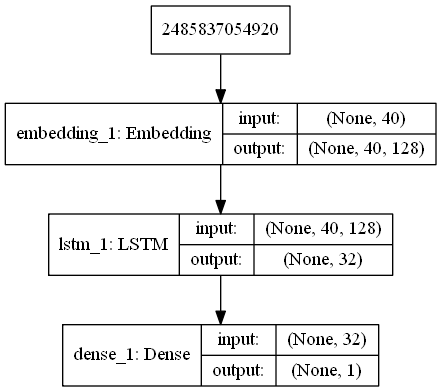

In [9]:
model1 = Sequential()
model1.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_length, mask_zero = True))
model1.add(LSTM(32, recurrent_dropout=0.2, return_sequences=False))
model1.add(Dense(1, activation = "sigmoid"))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model1.summary()
plot_model(model1, to_file='model1.png', show_shapes=True)
Image('model1.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 256)           98560     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 355,073
Trainable params: 355,073
Non-trainable params: 0
_________________________________________________________________


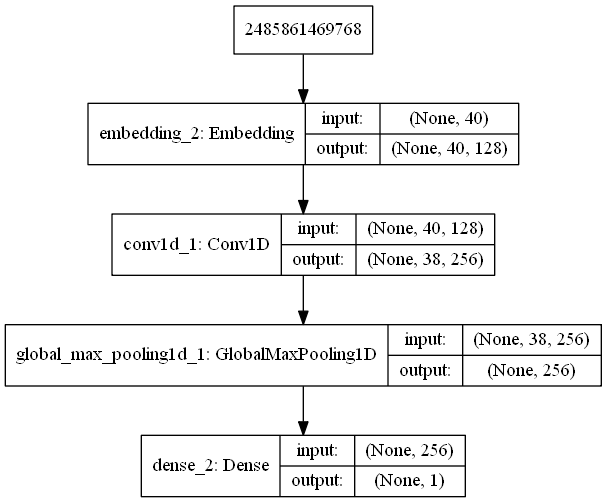

In [10]:
NUM_FILTERS=256
NUM_WORDS=3
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_length))
model2.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation = "sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model2.summary()
plot_model(model2, to_file='model2.png', show_shapes=True)
Image('model2.png')

In [11]:
history1 = b
history2 = model2.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/30
5668/5668 [==============================] - 3s 610us/step - loss: 0.6738 - acc: 0.6625 - val_loss: 0.6389 - val_acc: 0.6869
Epoch 2/30
5668/5668 [==============================] - 2s 396us/step - loss: 0.5818 - acc: 0.7454 - val_loss: 0.4818 - val_acc: 0.8223
Epoch 3/30
5668/5668 [==============================] - 2s 375us/step - loss: 0.3833 - acc: 0.8866 - val_loss: 0.2827 - val_acc: 0.9506
Epoch 4/30
5668/5668 [==============================] - 2s 392us/step - loss: 0.2306 - acc: 0.9592 - val_loss: 0.1870 - val_acc: 0.9654
Epoch 5/30
5668/5668 [==============================] - 2s 400us/step - loss: 0.1478 - acc: 0.9742 - val_loss: 0.1289 - val_acc: 0.9767
Epoch 6/30
5668/5668 [==============================] - 2s 384us/step - loss: 0.0945 - acc: 0.9875 - val_loss: 0.0902 - val_acc: 0.9831
Epoch 7/30
5668/5668 [==============================] - 2s 390us/step - loss: 0.0618 - acc: 0.9919 - val_loss: 0.0658 - val_acc: 0.9866


Epoch 30/30
5668/5668 [==============================] - 5s 868us/step - loss: 2.8688e-04 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9958


# 3. Plotting & Prediction

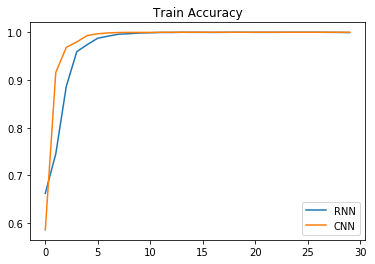

In [12]:
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.title('Train Accuracy')
plt.legend(['RNN','CNN'], loc='lower right')

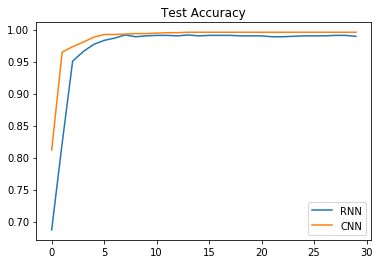

In [13]:
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.title('Test Accuracy')
plt.legend(['RNN','CNN'], loc='lower right')